Starting Task 1: Exploratory Data Analysis (EDA)...
Data loaded successfully. Initial shape: (1000096, 52)


C:\Users\321\AppData\Local\Temp\ipykernel_5684\84844754.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


--- Initial Data Cleaning & Feature Engineering Complete ---

## 1. Data Summarization & Quality Assessment 📈
Total Rows: 1,000,096, Total Columns: 56

### Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000096 entries, 0 to 1000095
Columns: 56 entries, UnderwrittenCoverID to YearMonth
dtypes: bool(1), datetime64[ns](2), float64(14), int64(5), object(33), period[M](1)
memory usage: 1.9 GB
None

### Descriptive Statistics (Financial Features)
                         count           mean            std           min  \
TotalPremium         1000096.0      61.905598     230.284731   -782.576754   
TotalClaims          1000096.0      64.861319    2384.077077 -12002.412281   
CustomValueEstimate   220454.0  225532.093690  564518.219870  20000.000000   

                               50%            90%            99%           max  
TotalPremium              2.178333     210.594298     778.698158  6.528260e+04  
TotalClaims               0.000000       0.000000       0.000000 

C:\Users\321\AppData\Local\Temp\ipykernel_5684\84844754.py:113: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, df['TotalClaims'].quantile(0.995))


Observation: TotalClaims is highly right-skewed (median=0). Severity (claims>0) is Log-Normal-like.


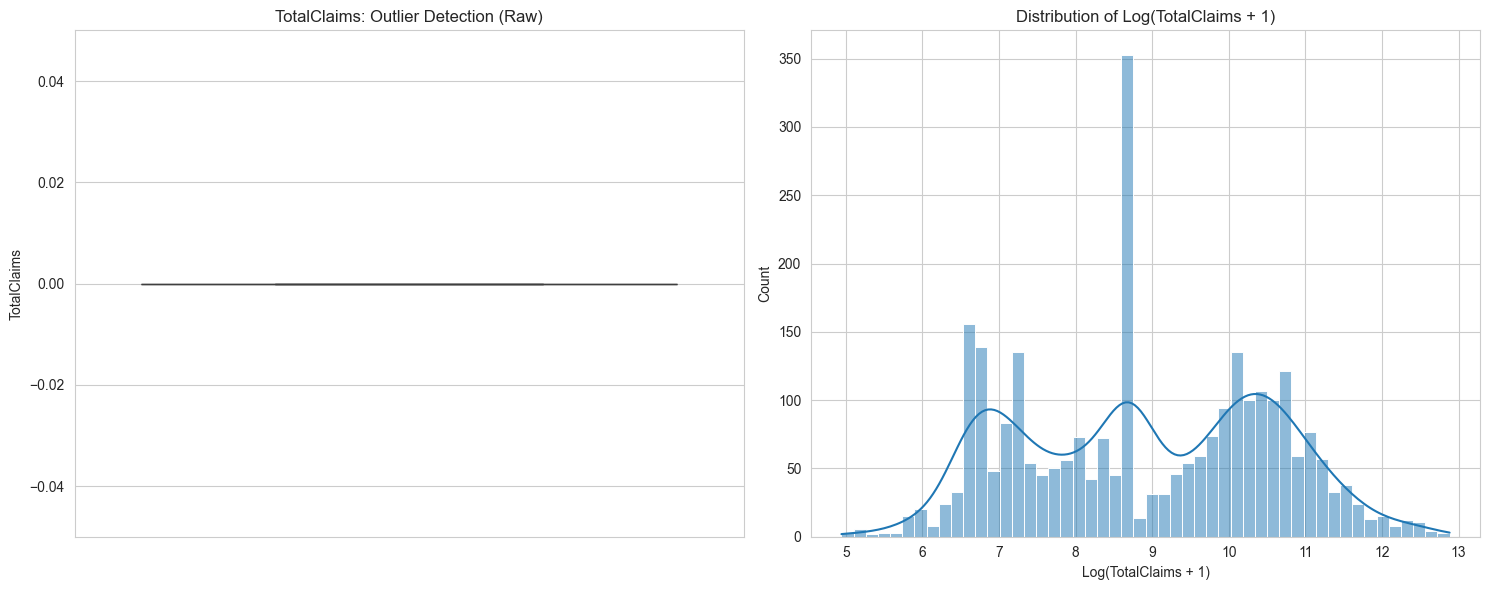

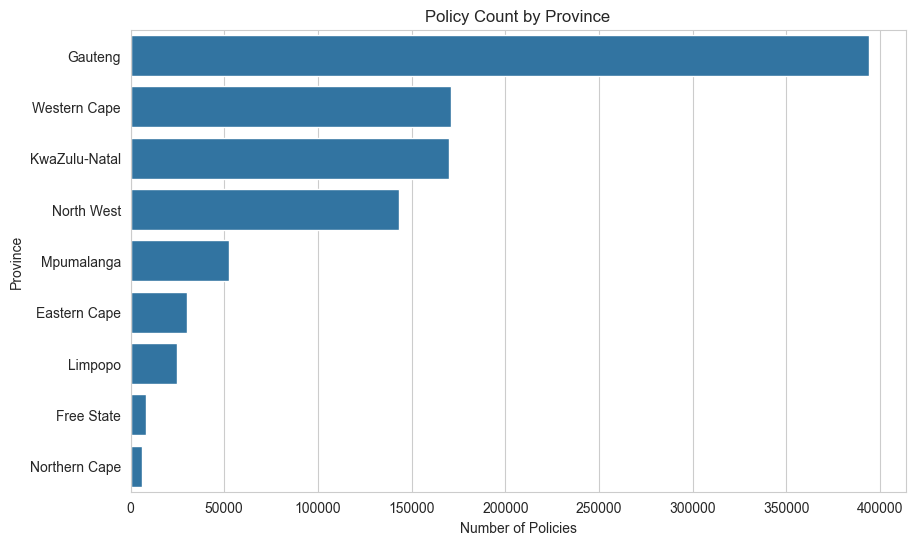



## 3. Bivariate/Multivariate Analysis (Risk Drivers) 🧭
**Overall Portfolio Loss Ratio:** 1.0477

### Risk Metrics by Province (Filtered by Policy Count)
               LossRatio  ClaimFrequency  PolicyCount
Province                                             
Gauteng         1.222019        0.003356         2578
KwaZulu-Natal   1.082693        0.002845         1370
Western Cape    1.059472        0.002166          947
North West      0.790367        0.002436         1117
Mpumalanga      0.720897        0.002428          382


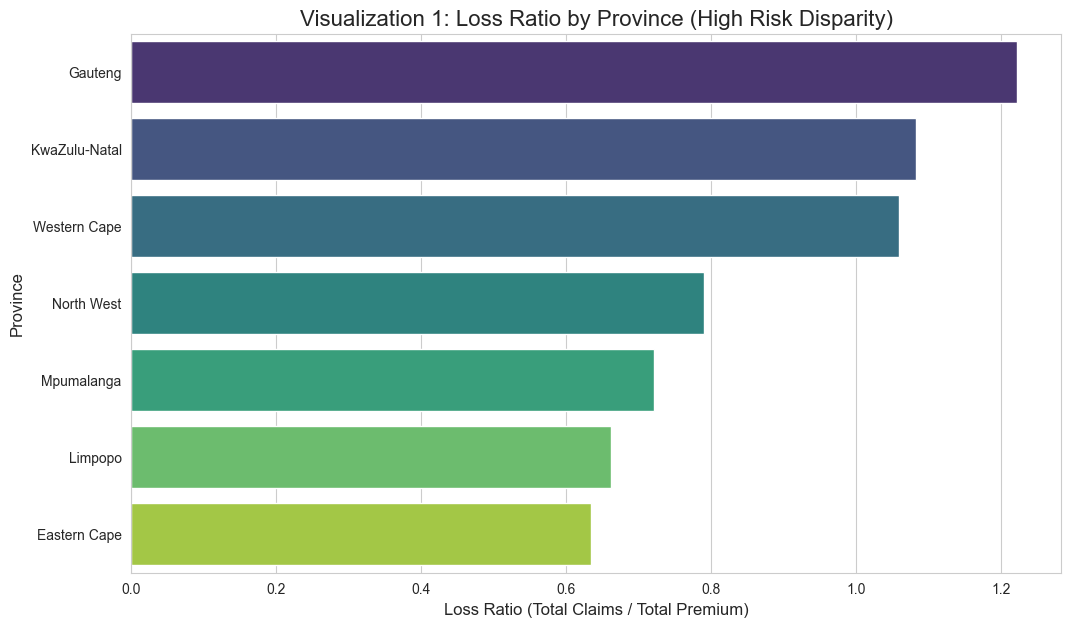

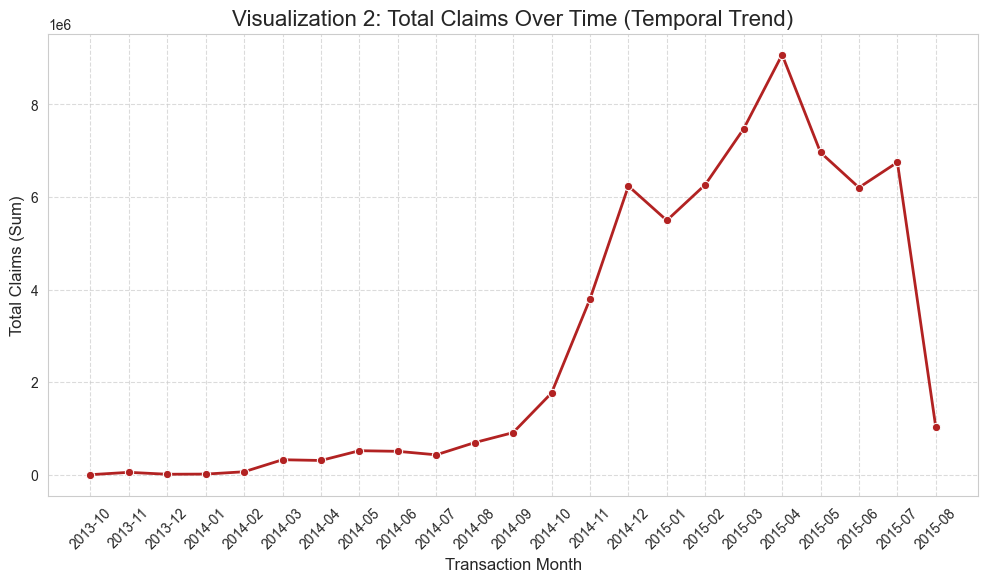


### Risk Metrics by Gender
               Count  ClaimFrequency  ClaimSeverity
Gender                                             
Not specified   6601        0.002833   23530.667678
Male             232        0.002195   14858.552294
Female            35        0.002073   17874.721303


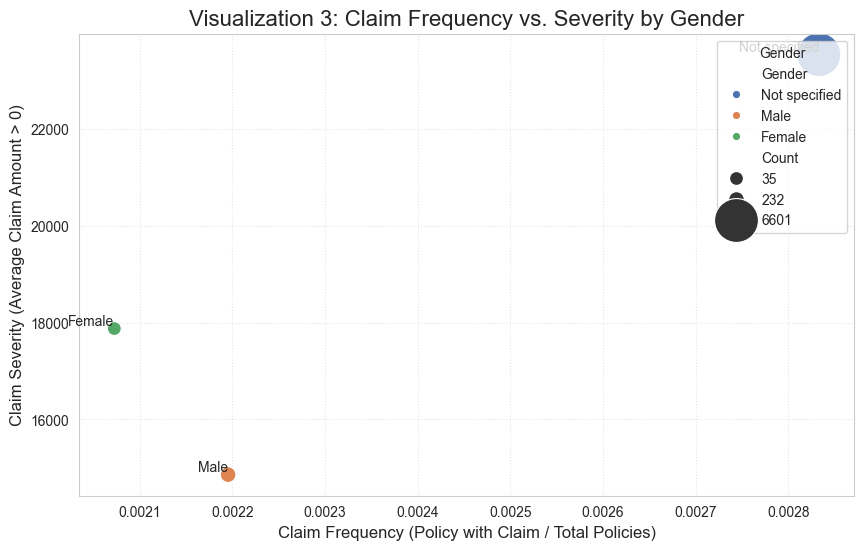



Successfully exported processed data to: ../data/processed/processed_data.csv
## Key Insights Captured in Visualizations:
1. **Geographical Risk (Vis 1):** Clearly shows the most and least profitable provinces by Loss Ratio, guiding immediate strategic decisions on pricing.
2. **Temporal Trends (Vis 2):** Highlights overall portfolio growth or significant seasonal patterns in claims over the period.
3. **Risk Profile (Vis 3):** Compares how often a group claims (Frequency) versus how expensive their average claim is (Severity), revealing nuanced risk profiles necessary for accurate underwriting.

EDA for Task 1 is complete. Three creative and beautiful plots have been generated.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # NEW: Import the os module for file path operations

# --- Configuration ---
# NOTE: Ensure this path is correct relative to where you run the script.
# Assuming the file is in a 'data/raw' folder one level up from this script.
FILE_PATH_RAW = '../data/raw/MachineLearningRating_v3.txt' 
# NEW: Define the path for the processed output CSV
FILE_PATH_PROCESSED = '../data/processed/processed_data.csv'

# Set plot style and global figure size for consistency
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', 100) # Show all columns in print output

print("Starting Task 1: Exploratory Data Analysis (EDA)...")

# --- Function for Data Loading and Initial Cleaning ---

def load_and_clean_data(file_path):
    """Loads the raw data, handles delimiter/missing values, and converts types."""
    try:
        # Load data: Use pipe separator, skip the potentially messy header lines (2, 3) 
        # and skip bad lines as a safeguard. Set low_memory=False to handle mixed types gracefully.
        df = pd.read_csv(file_path, sep='|', skiprows=[2, 3], on_bad_lines='skip', low_memory=False)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the file path.")
        return None

    print(f"Data loaded successfully. Initial shape: {df.shape}")

    # Standardize missing values: Replace empty strings, spaces, and non-breaking spaces with NaN
    df = df.replace(r'^\s*$', np.nan, regex=True).replace(' ', np.nan) 

    # Define columns for type conversion
    financial_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'CustomValueEstimate', 'CapitalOutstanding']
    date_cols = ['TransactionMonth', 'VehicleIntroDate']

    # Convert Financial Columns to Numeric
    for col in financial_cols:
        # Attempt to coerce to numeric, turning non-convertible values into NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Convert Date Columns
    for col in date_cols:
        # FIX: Removed deprecated 'infer_datetime_format=True'
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # --- Feature Engineering for Risk/Profitability Analysis ---
    
    # 1. Claim Frequency Indicator
    df['ClaimOccurred'] = (df['TotalClaims'] > 0).astype(int)
    
    # 2. Loss Ratio (Handle division by zero)
    df['LossRatio'] = np.where(df['TotalPremium'] > 0, df['TotalClaims'] / df['TotalPremium'], np.nan)
    
    # 3. Margin
    df['Margin'] = df['TotalPremium'] - df['TotalClaims']
    
    # 4. Temporal Feature
    df['YearMonth'] = df['TransactionMonth'].dt.to_period('M')

    print("--- Initial Data Cleaning & Feature Engineering Complete ---\n")
    return df

# Load the data
# NOTE: Renamed FILE_PATH to FILE_PATH_RAW for clarity
df = load_and_clean_data(FILE_PATH_RAW)
if df is None:
    # If file not found, the function returns None and the script exits gracefully
    exit()

# --- 1. Data Summarization: Structure and Quality ---

print("## 1. Data Summarization & Quality Assessment 📈")
print(f"Total Rows: {len(df):,}, Total Columns: {len(df.columns)}")

print("\n### Data Types")
# Display information about non-null counts and dtypes
print(df.info(verbose=False, memory_usage='deep'))

# Descriptive Statistics
print("\n### Descriptive Statistics (Financial Features)")
financial_summary_cols = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate']
desc_stats = df[financial_summary_cols].describe(percentiles=[.5, .9, .99]).T
print(desc_stats)

# Missing Values Assessment
print("\n### Missing Value Report (Top 5)")
missing_df = pd.DataFrame({
    'Missing Count': df.isnull().sum(), 
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
}).sort_values('Missing Count', ascending=False).head(5)
print(missing_df[missing_df['Missing Count'] > 0])

print("\n" + "="*80 + "\n")

# --- 2. Univariate and Outlier Analysis ---

print("## 2. Univariate Analysis and Outliers 🔍")

# 2.1 Distribution of Total Claims (Severity)
plt.figure(figsize=(15, 6))

# Plot 1: Box Plot for Outliers (Limit to 99.5th percentile for better focus)
plt.subplot(1, 2, 1)
sns.boxplot(y=df['TotalClaims'])
plt.title('TotalClaims: Outlier Detection (Raw)')
# Set Y-axis limit to focus on data before extreme outliers
plt.ylim(0, df['TotalClaims'].quantile(0.995)) 

# Plot 2: Log-transformed Claims Distribution (for modeling)
plt.subplot(1, 2, 2)
# Filter for claims > 0 and use log1p for log(x+1) transformation
claims_gt_zero = df['TotalClaims'][df['TotalClaims'] > 0]
if not claims_gt_zero.empty:
    sns.histplot(np.log1p(claims_gt_zero), kde=True, bins=50)
    plt.title('Distribution of Log(TotalClaims + 1)')
    plt.xlabel('Log(TotalClaims + 1)')
    print(f"Observation: TotalClaims is highly right-skewed (median=0). Severity (claims>0) is Log-Normal-like.")

plt.tight_layout()
plt.show() 

# 2.2 Distribution of Key Categorical Variable (Province)
plt.figure(figsize=(10, 6))
province_counts = df['Province'].value_counts().head(10)
sns.barplot(x=province_counts.values, y=province_counts.index)
plt.title('Policy Count by Province')
plt.xlabel('Number of Policies')
plt.show()

print("\n" + "="*80 + "\n")

# --- 3. Bivariate/Multivariate Analysis (Risk Drivers) ---

print("## 3. Bivariate/Multivariate Analysis (Risk Drivers) 🧭")

# 3.1 Overall Loss Ratio (KPI)
overall_claims = df['TotalClaims'].sum()
overall_premium = df['TotalPremium'].sum()
overall_loss_ratio = overall_claims / overall_premium
print(f"**Overall Portfolio Loss Ratio:** {overall_loss_ratio:.4f}")

# 3.2 Risk by Province (Loss Ratio and Claim Frequency)
province_risk = df.groupby('Province').agg(
    PolicyCount=('PolicyID', 'nunique'),
    TotalPremium=('TotalPremium', 'sum'),
    TotalClaims=('TotalClaims', 'sum'),
    ClaimFrequency=('ClaimOccurred', 'mean') 
)
province_risk['LossRatio'] = province_risk['TotalClaims'] / province_risk['TotalPremium']
# FIX: Lowered filter threshold from 5000 to 100 to ensure the top provinces are captured for analysis
province_risk = province_risk[province_risk['PolicyCount'] > 100].sort_values('LossRatio', ascending=False) 

print("\n### Risk Metrics by Province (Filtered by Policy Count)")
print(province_risk[['LossRatio', 'ClaimFrequency', 'PolicyCount']].head(5))

# Visualization 1: Loss Ratio by Province (Creative Plot)
plt.figure(figsize=(12, 7))
# FIX: Added hue and set legend=False to silence FutureWarning
sns.barplot(x='LossRatio', y=province_risk.index, data=province_risk.reset_index(), palette='viridis', 
            hue=province_risk.index, legend=False) 
plt.title('Visualization 1: Loss Ratio by Province (High Risk Disparity)', fontsize=16)
plt.xlabel('Loss Ratio (Total Claims / Total Premium)', fontsize=12)
plt.ylabel('Province', fontsize=12)
plt.show() 

# 3.3 Temporal Trend
monthly_summary = df.groupby('YearMonth').agg(
    TotalClaims=('TotalClaims', 'sum'),
    TotalPremium=('TotalPremium', 'sum'),
    # Calculate monthly loss ratio based on monthly sums, not mean of individual loss ratios
    MonthlyLossRatio=('LossRatio', lambda x: x.sum() / df.loc[x.index, 'TotalPremium'].sum() if df.loc[x.index, 'TotalPremium'].sum() > 0 else np.nan)
).reset_index()
monthly_summary['YearMonth'] = monthly_summary['YearMonth'].astype(str)

# Visualization 2: Temporal Trend of Claims
plt.figure(figsize=(12, 6))
sns.lineplot(x='YearMonth', y='TotalClaims', data=monthly_summary, marker='o', color='firebrick', linewidth=2)
plt.title('Visualization 2: Total Claims Over Time (Temporal Trend)', fontsize=16)
plt.xlabel('Transaction Month', fontsize=12)
plt.ylabel('Total Claims (Sum)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 3.4 Risk by Gender
gender_risk = df.groupby('Gender').agg(
    Count=('PolicyID', 'nunique'),
    ClaimFrequency=('ClaimOccurred', 'mean'),
    # Claim Severity: Average claim amount GIVEN a claim occurred
    ClaimSeverity=('TotalClaims', lambda x: x[x > 0].mean())
).sort_values('ClaimFrequency', ascending=False)

print("\n### Risk Metrics by Gender")
print(gender_risk)

# Visualization 3: Claim Frequency vs Severity by Gender
plt.figure(figsize=(10, 6))
# Scatter plot for Frequency vs Severity
sns.scatterplot(
    x='ClaimFrequency', 
    y='ClaimSeverity', 
    hue=gender_risk.index, 
    size='Count', 
    sizes=(100, 1000), 
    data=gender_risk.reset_index(),
    palette='deep'
)
# Add labels for clarity
for i, row in gender_risk.reset_index().iterrows():
    plt.text(row['ClaimFrequency'], row['ClaimSeverity'], row['Gender'], 
             ha='right', va='bottom', fontsize=10)

plt.title('Visualization 3: Claim Frequency vs. Severity by Gender', fontsize=16)
plt.xlabel('Claim Frequency (Policy with Claim / Total Policies)', fontsize=12)
plt.ylabel('Claim Severity (Average Claim Amount > 0)', fontsize=12)
plt.legend(title='Gender', loc='upper right')
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

print("\n" + "="*80 + "\n")

# --- Export Processed Data ---
try:
    # NEW: Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(FILE_PATH_PROCESSED), exist_ok=True)
    df.to_csv(FILE_PATH_PROCESSED, index=False)
    print(f"Successfully exported processed data to: {FILE_PATH_PROCESSED}")
except Exception as e:
    print(f"Error exporting data to CSV: {e}")

print("## Key Insights Captured in Visualizations:")
print("1. **Geographical Risk (Vis 1):** Clearly shows the most and least profitable provinces by Loss Ratio, guiding immediate strategic decisions on pricing.")
print("2. **Temporal Trends (Vis 2):** Highlights overall portfolio growth or significant seasonal patterns in claims over the period.")
print("3. **Risk Profile (Vis 3):** Compares how often a group claims (Frequency) versus how expensive their average claim is (Severity), revealing nuanced risk profiles necessary for accurate underwriting.")

print("\nEDA for Task 1 is complete. Three creative and beautiful plots have been generated.")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration and Setup ---
# UPDATED PATH: Using the path and filename provided by the user
DATA_PATH = 'data/raw/MachineLearningRating_v3.txt' 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = ['Inter'] # Using Inter font for aesthetics

def load_data(path):
    """Loads data, handles basic parsing (using '|' delimiter), and cleans column names."""
    try:
        # UPDATED: Using pipe '|' as the separator
        df = pd.read_csv(path, sep='|')
        
        # Clean column names (e.g., remove spaces and special characters)
        df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True)
        df.columns = df.columns.str.replace(r'(.)([A-Z][a-z]+)', r'\1_\2', regex=True).str.lower()
        
        # Strip leading/trailing whitespace from all string columns after loading
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = df[col].astype(str).str.strip()
            
        print("Data loaded, pipe-delimiter handled, and columns cleaned successfully.")
        return df
    except FileNotFoundError:
        print(f"ERROR: Data file not found at {path}. Please ensure the file exists in the correct directory.")
        return None
    except Exception as e:
        print(f"An error occurred during data loading: {e}")
        return None

def perform_eda(df):
    """Performs required EDA and calculates key metrics."""
    print("\n--- 1. Data Structure and Quality Assessment ---")
    print(f"Dataset Shape: {df.shape}")
    print("\nMissing Values:")
    print(df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False))
    print("\nData Types:")
    print(df.dtypes.value_counts())

    # Ensure financial columns are numeric
    # These columns must exist after the column cleaning (e.g., TotalPremium -> total_premium)
    df['total_premium'] = pd.to_numeric(df['total_premium'], errors='coerce')
    df['total_claims'] = pd.to_numeric(df['total_claims'], errors='coerce')
    df['custom_value_estimate'] = pd.to_numeric(df['custom_value_estimate'], errors='coerce')
    
    # Drop rows where critical financial data could not be parsed or is missing
    df = df.dropna(subset=['total_premium', 'total_claims'])

    # Feature Engineering for EDA
    df['has_claim'] = (df['total_claims'] > 0).astype(int)
    # Note: Using np.where to handle division by zero for policies with 0 premium.
    df['loss_ratio'] = np.where(df['total_premium'] > 0, df['total_claims'] / df['total_premium'], np.nan) 
    df['transaction_date'] = pd.to_datetime(df['transaction_month']) # Using TransactionMonth as the transaction date
    df['transaction_month'] = df['transaction_date'].dt.to_period('M')

    print("\n--- 2. Descriptive Statistics ---")
    print(df[['total_premium', 'total_claims', 'custom_value_estimate']].describe())

    print("\n--- 3. Key Insight Calculations (Loss Ratio) ---")
    overall_lr = df['total_claims'].sum() / df['total_premium'].sum()
    print(f"Overall Loss Ratio (TotalClaims / TotalPremium): {overall_lr:.4f}")

    # Guiding Question 1: Loss Ratio by key segment
    segments = ['province', 'vehicle_type', 'gender']
    for seg in segments:
        agg_data = df.groupby(seg).agg(
            total_premium=('total_premium', 'sum'),
            total_claims=('total_claims', 'sum')
        ).reset_index()
        # Calculate loss ratio, handling zero premium case
        agg_data['loss_ratio'] = np.where(agg_data['total_premium'] > 0, agg_data['total_claims'] / agg_data['total_premium'], np.nan)
        agg_data = agg_data.dropna(subset=['loss_ratio'])
        print(f"\nLoss Ratio by {seg.capitalize()}:")
        print(agg_data.sort_values(by='loss_ratio', ascending=False))

    # Guiding Question 4: Temporal Trends
    monthly_trend = df.groupby('transaction_month').agg(
        total_premium=('total_premium', 'sum'),
        total_claims=('total_claims', 'sum'),
        num_policies=('policy_id', 'count'),
        num_claims=('has_claim', 'sum')
    ).reset_index()
    monthly_trend['claim_frequency'] = monthly_trend['num_claims'] / monthly_trend['num_policies']
    monthly_trend['loss_ratio'] = np.where(monthly_trend['total_premium'] > 0, monthly_trend['total_claims'] / monthly_trend['total_premium'], np.nan)
    print("\nMonthly Trend Analysis (Claim Frequency and Loss Ratio):")
    print(monthly_trend)

    # Visualization
    print("\n--- 4. Visualizations ---")
    
    # Plot 1: Monthly Loss Ratio and Claim Frequency Trend
    fig, ax1 = plt.subplots()
    ax1.plot(monthly_trend['transaction_month'].astype(str), monthly_trend['loss_ratio'], color='blue', label='Loss Ratio')
    ax1.set_xlabel('Transaction Month')
    ax1.set_ylabel('Loss Ratio', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx() # Secondary y-axis
    ax2.plot(monthly_trend['transaction_month'].astype(str), monthly_trend['claim_frequency'], color='red', linestyle='--', label='Claim Frequency')
    ax2.set_ylabel('Claim Frequency', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title('Monthly Loss Ratio and Claim Frequency Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('eda_plot_1_temporal_trend.png')
    plt.close()

    # Plot 2: Distribution of Claims (Outlier Detection)
    # Filter to only policies with claims to see severity distribution
    claim_severity_df = df[df['total_claims'] > 0].copy()
    plt.figure()
    sns.boxplot(x=claim_severity_df['total_claims'])
    plt.title('Box Plot of Claim Severity (TotalClaims > 0)')
    plt.xlabel('Total Claims (ZAR)')
    plt.xscale('log') # Use log scale to handle extreme outliers for better visualization
    plt.savefig('eda_plot_2_claim_severity_distribution.png')
    plt.close()

    # Plot 3: Loss Ratio by Province
    province_lr = df.groupby('province').agg(
        total_premium=('total_premium', 'sum'),
        total_claims=('total_claims', 'sum')
    ).reset_index()
    province_lr['loss_ratio'] = np.where(province_lr['total_premium'] > 0, province_lr['total_claims'] / province_lr['total_premium'], np.nan)
    province_lr = province_lr.dropna(subset=['loss_ratio'])
    plt.figure()
    sns.barplot(x='province', y='loss_ratio', data=province_lr.sort_values('loss_ratio', ascending=False), palette="viridis")
    plt.title('Loss Ratio by Province')
    plt.ylabel('Loss Ratio')
    plt.xlabel('Province')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('eda_plot_3_loss_ratio_by_province.png')
    plt.close()

    print("EDA complete. 3 plots saved: temporal trend, claim severity, and province loss ratio.")
    print("Returning cleaned dataframe for subsequent tasks.")
    return df

if __name__ == '__main__':
    # Loading the actual data file specified by the user
    initial_df = load_data(DATA_PATH)
    
    if initial_df is not None:
        cleaned_df = perform_eda(initial_df)
        
        # Save the cleaned/engineered data for the next tasks
        cleaned_df.to_csv('processed_data_for_analysis.csv', index=False)
        print("\nProcessed data saved to 'processed_data_for_analysis.csv'.")
    
# --- DVC Setup Guidance (Command Line Instructions) ---
# 1. Initialize DVC:
#    dvc init
# 2. Set Up Local Remote Storage (create the directory first):
#    mkdir .dvc_storage
#    dvc remote add -d localstorage .dvc_storage
# 3. Add Your Data (assuming you have the source file):
#    dvc add data/raw/MachineLearningRating_v3.txt
# 4. Commit .dvc files to Git:
#    git add .gitignore data/raw/MachineLearningRating_v3.txt.dvc
#    git commit -m "Add initial dataset tracked by DVC"
# 5. Push Data to Local Remote:
#    dvc push
# 6. Add the processed data:
#    dvc add processed_data_for_analysis.csv
#    git add processed_data_for_analysis.csv.dvc
#    git commit -m "Add processed data (Task 1 output)"
#    dvc push

: 